<a href="https://colab.research.google.com/github/ram130849/spatio_temporal_modelling/blob/main/Spatio_Temporal_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 75.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-69i7jb7v
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [2]:
!pip install torch-geometric-temporal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 627.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 33.8 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86726 sha256=814d4e4a21878c0505eae86f0cc1e9585819559f4e9c2da0c08a4b08076fbd0e
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires panda

In [3]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader,ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 32

In [5]:
loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset)))
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7ff0dc36add0>
Number of samples / sequences:  52082
Data(x=[325, 2, 12], edge_index=[2, 2694], edge_attr=[2694], y=[325, 2, 12])


In [6]:
# Get the length of the train dataset.
print(len(list(train_dataset)))

10416


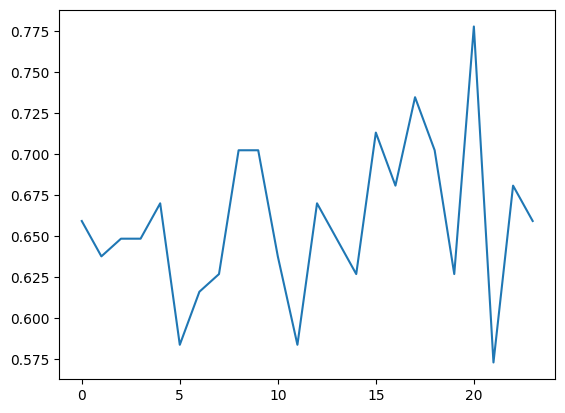

In [7]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0][1].item() for bucket in list(dataset)[:hours]]

plt.plot(sensor_labels)

In [7]:
# Train Dataset Loader
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array([target[:,1,:] for target in train_dataset.targets]) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE) # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array([target[:,1,:] for target in test_dataset.targets]) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [8]:
class RecurrentGCN(torch.nn.Module):

    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [9]:
model = RecurrentGCN(node_features = 2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

RecurrentGCN(
  (recurrent): DCRNN(
    (conv_x_z): DConv(34, 32)
    (conv_x_r): DConv(34, 32)
    (conv_x_h): DConv(34, 32)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
for epoch in tqdm(range(10)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        for i in range(12):
            y_hat = model(snapshot.x[:,:,i], snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y[:,:,i])**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [10]:
model = TemporalGNN(node_features=2, periods=12, batch_size=2)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

model.train()

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [11]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    break;

In [12]:
model.train()

for epoch in range(10):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0:
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.36704483553767203
0.30042528789490464
0.2753985928247372
Epoch 0 train RMSE: 0.2750
0.2268463592417538
0.21988282655365765
0.21678639798114696
Epoch 1 train RMSE: 0.2155
0.1917226859368384
0.20487427280284465
0.20284387244532506
Epoch 2 train RMSE: 0.2058
0.20269411478191615
0.20475407406687737
0.20516429604341588
Epoch 3 train RMSE: 0.2011
0.17812190489843488
0.1847527021449059
0.19619547010709842
Epoch 4 train RMSE: 0.1995
0.19491174532100558
0.19166828102897854
0.19760828231461347
Epoch 5 train RMSE: 0.1961
0.20101577285677194
0.19531604737043382
0.19567638913169502
Epoch 6 train RMSE: 0.1949
0.19163775896653534
0.19316223477944733
0.19378940299774208
Epoch 7 train RMSE: 0.1920
0.19750637393444775
0.19207002621144056
0.19546719916785757
Epoch 8 train RMSE: 0.1938
0.1812471772916615
0.19175253626890482
0.19283431762208542
Epoch 9 train RMSE: 0.1917


In [13]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs.to(DEVICE), static_edge_index.to(DEVICE))
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.1902


In [14]:
sensor = 112
timestep = 10 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

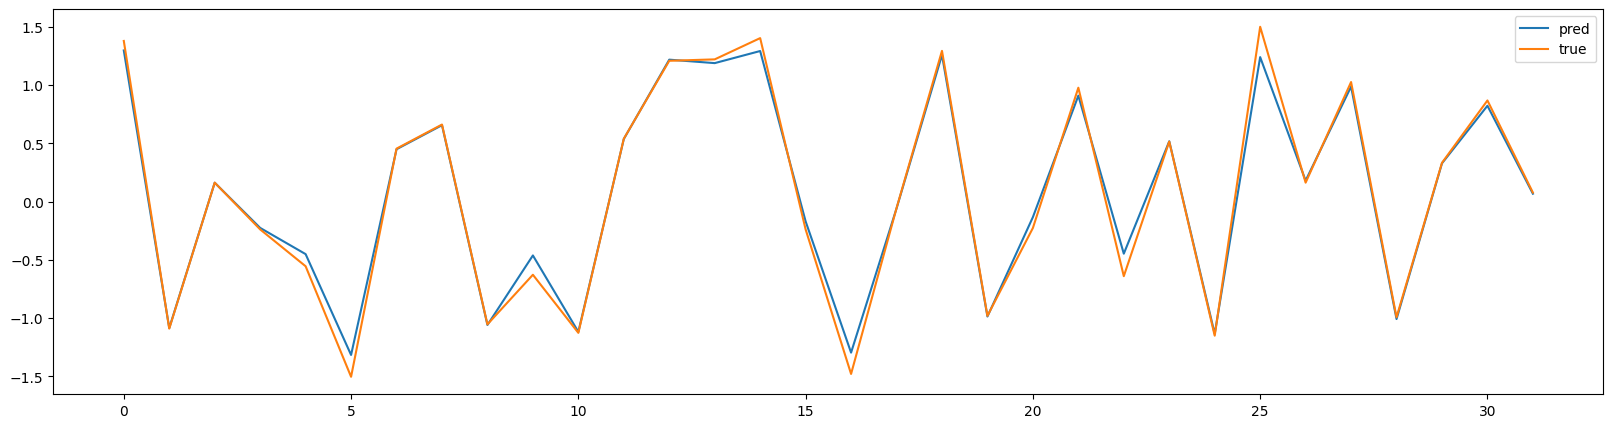

In [15]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

In [20]:
loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [21]:
print(next(iter(train_dataset)))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])
